# Case study: Interface design

This chapter presents a case study that demonstrates a process for designing functions that work together.

It introduces the `matplotlib` library, which allows us to create visual representations of data. While standard Python allows us to calculate numbers, `matplotlib` allows us to visualize them as spatial shapes.

This is our first step into the **Vector Data Model** used in GIS. In the vector model, features like buildings, roads, and boundaries are represented as:
* **Points**: Single (x, y) coordinate pairs.
* **Lines**: A sequence of connected points.
* **Polygons**: A closed sequence of lines (where the start and end points are the same).

In this chapter, we will write functions to calculate these coordinates and draw them, moving from simple squares to complex polygons.

## The Matplotlib Module

To use `matplotlib`, we need to import it. We also need the `math` module to calculate coordinates (using sine and cosine) based on angles.

In [35]:
import matplotlib.pyplot as plt
import math

Using `matplotlib` is straightforward. We provide it with two lists: one for the X coordinates and one for the Y coordinates.

Here is how we can draw a simple line segment from point (0, 0) to point (100, 100).

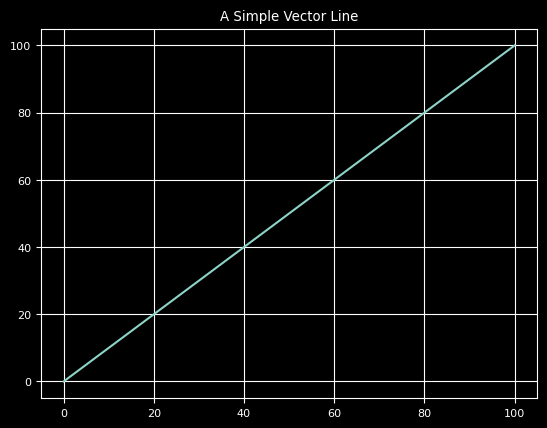

In [36]:
# Define the coordinates
x_coords = [0, 100]
y_coords = [0, 100]

# Plot the line
plt.plot(x_coords, y_coords)

# Add a title and grid for context
plt.title("A Simple Vector Line")
plt.grid(True)
plt.show()

## Simple Repetition

In GIS, a polygon is just a list of points where the first and last point are the same. 

To draw a square, we could manually list the four corners: `(0,0)`, `(100, 0)`, `(100, 100)`, `(0, 100)`, and back to `(0,0)`.

However, we can also calculate these points using a loop. This mimics how a surveyor might measure a boundary: "Walk 100 meters, turn 90 degrees left, repeat."

We can write a loop that calculates the new `x` and `y` coordinates using basic trigonometry (`math.cos` and `math.sin`) and plots a line to the new point.

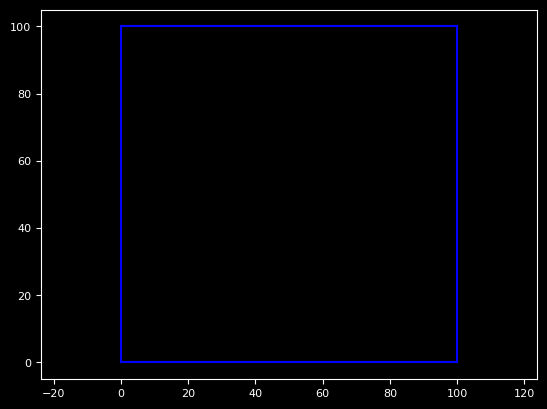

In [37]:
x = 0
y = 0
angle = 0
length = 100

for i in range(4):
    # Calculate the new position based on current angle
    # Note: math.cos takes radians, so we convert degrees to radians
    new_x = x + length * math.cos(math.radians(angle))
    new_y = y + length * math.sin(math.radians(angle))
    
    # Draw a line segment from the old position to the new position
    plt.plot([x, new_x], [y, new_y], 'b-') # 'b-' means blue line
    
    # Update our current position
    x = new_x
    y = new_y
    
    # Turn 90 degrees to the left
    angle += 90

plt.axis('equal') # Ensure the square looks like a square, not a rectangle
plt.show()

The syntax `range(4)` creates a sequence of four numbers: 0, 1, 2, and 3. The loop runs the code body four times, once for each side of the square.

This concept—calculating the next vertex based on a direction and distance—is fundamental to how vector data is created from survey measurements.

## Encapsulation

The first exercise asks you to put your square-drawing code into a function definition and then call the function, passing a parameter for the `length` of the side.

This is called **encapsulation**. It allows us to reuse the "square" logic to draw squares of any size without rewriting the coordinate math every time.

In [38]:
def square(length):
    x, y = 0, 0
    angle = 0
    
    for i in range(4):
        new_x = x + length * math.cos(math.radians(angle))
        new_y = y + length * math.sin(math.radians(angle))
        
        plt.plot([x, new_x], [y, new_y], 'b-')
        
        x, y = new_x, new_y
        angle += 90
        
    plt.axis('equal')
    plt.show()

When you define a function, it doesn't run immediately. You have to call it:

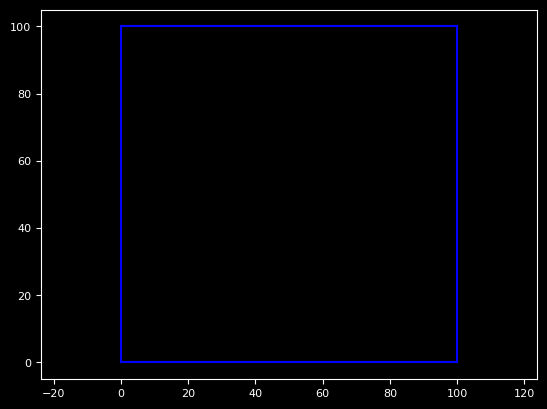

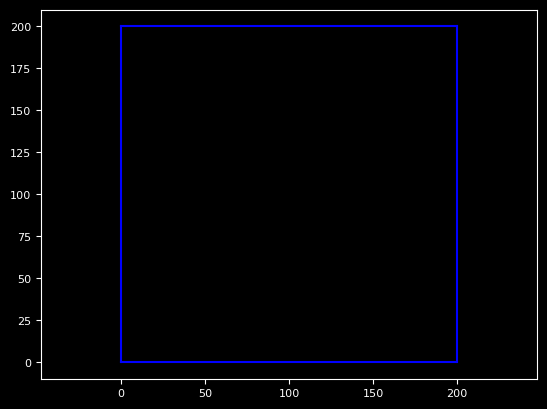

In [39]:
square(100)
square(200)

## Generalization

The next step is to add a `n` parameter to the function so it can draw regular polygons with any number of sides (e.g., a hexagon or octagon).

To do this, we need to generalize our angle logic. A square has 4 sides and turns 90 degrees ($360 / 4$). An $n$-sided polygon turns $360 / n$ degrees at each vertex.

In [40]:
def polygon(n, length):
    x, y = 0, 0
    angle = 0
    turn_angle = 360 / n
    
    for i in range(n):
        new_x = x + length * math.cos(math.radians(angle))
        new_y = y + length * math.sin(math.radians(angle))
        
        plt.plot([x, new_x], [y, new_y], 'r-') # 'r-' for red line
        
        x, y = new_x, new_y
        angle += turn_angle
        
    plt.axis('equal')
    plt.show()

Now we can use this single function to draw a triangle (3 sides) or an octagon (8 sides).

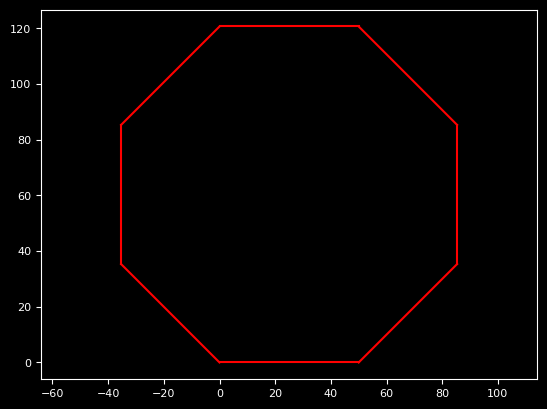

In [41]:
polygon(n=8, length=50)

This illustrates **generalization**: adding a parameter to a function to make it more general-purpose. In GIS terms, we have created a function that can generate the vector geometry for any regular building footprint or boundary.

## Interface design

The next step is to write `circle`, which takes a radius, `r`.

A computer cannot draw a true mathematical curve; it approximates curves using many short straight lines. A circle is essentially a polygon with many sides.

We can use our `polygon` function to approximate a circle.

In [42]:
def circle(r):
    circumference = 2 * math.pi * r
    n = 50
    length = circumference / n
    polygon(n, length)

This works, but the interface (the parameters) is a bit indirect. We have to compute `circumference` and `length` internally. 

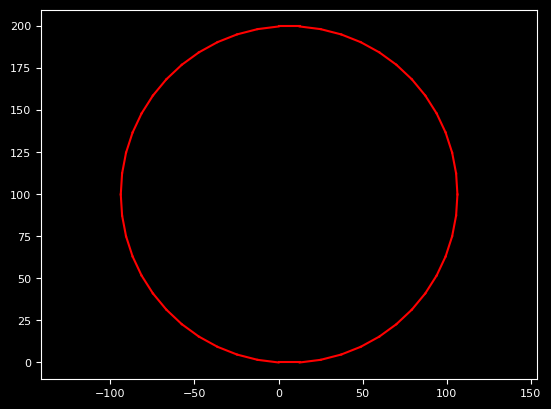

In [43]:
circle(r=100)

The **interface** of a function is a summary of how it is used: what are the parameters? What does the function do? And what is the return value? An interface is "clean" if it allows the caller to do what they want without dealing with unnecessary details.

In this example, `r` is what the caller wants to specify, but inside the function, we have to translate that into the vector data model (points and lines) using `n` and `length`.

## Refactoring

We can improve our code by rearranging it. The current `polygon` function plots lines immediately. In a real GIS workflow, we often want to *generate* the list of coordinates first, and then plot them later or save them to a file.

Let's **refactor** `polygon` to separate the calculation of the geometry from the drawing. This makes the code more modular.

In [44]:
def get_polygon_coords(n, length):
    x, y = 0, 0
    angle = 0
    turn_angle = 360 / n
    
    x_coords = [0]
    y_coords = [0]
    
    for i in range(n):
        new_x = x + length * math.cos(math.radians(angle))
        new_y = y + length * math.sin(math.radians(angle))
        
        x_coords.append(new_x)
        y_coords.append(new_y)
        
        x, y = new_x, new_y
        angle += turn_angle
        
    return x_coords, y_coords

def draw_polygon(n, length):
    xs, ys = get_polygon_coords(n, length)
    plt.plot(xs, ys)
    plt.axis('equal')
    plt.show()

This new version returns lists of coordinates—exactly how a Shapefile or GeoJSON stores data. `draw_polygon` handles the visualization.

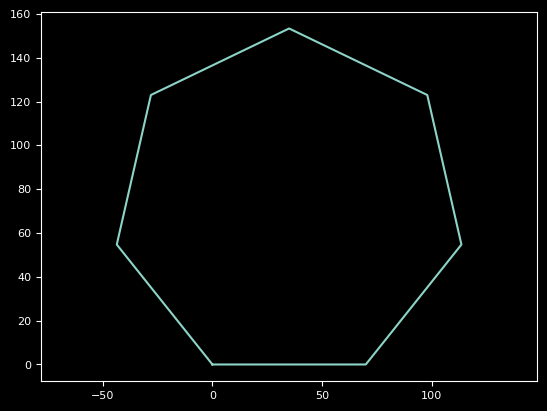

In [45]:
draw_polygon(7, 70)

## Exercises

### Exercise 1

Write a function called `arc` that takes `r` and `angle` as parameters and draws a portion of a circle (an arc).

Hint: You can use the `get_polygon_coords` logic but stop before `i` reaches `n`, or modify the loop range based on the angle fraction.

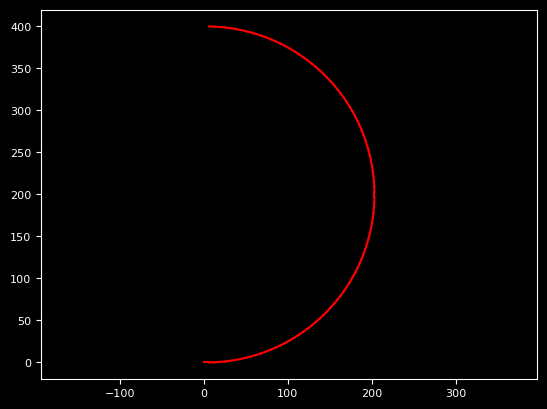

In [53]:
def polygon(n, length,pangle = 360):
    x, y = 0, 0
    angle = 0
    turn_angle = pangle / n
    
    for i in range(n):
        new_x = x + length * math.cos(math.radians(angle))
        new_y = y + length * math.sin(math.radians(angle))
        
        plt.plot([x, new_x], [y, new_y], 'r-') # 'r-' for red line
        
        x, y = new_x, new_y
        angle += turn_angle
        
    plt.axis('equal')
    plt.show()

def arc(r,angle):
    circumference = 2 * math.pi * r
    n = 100
    length = circumference / n
    polygon(n, length, angle)
arc(100,180)

### Exercise 2

Write a function called `flower` that uses your `arc` function to draw a flower with `n` petals. 

This simulates creating a complex vector feature (like a multipart polygon) from simple geometric primitives.